# Install requirements for object detection

In [1]:
!pip install cython

In [2]:
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
# !pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' --> run from conda

In [3]:
ROOT_DIR='PennFudanPed/'
MASKS_PATH='PennFudanPed/PedMasks/'
IMAGES_PATH='PennFudanPed/PNGImages/'

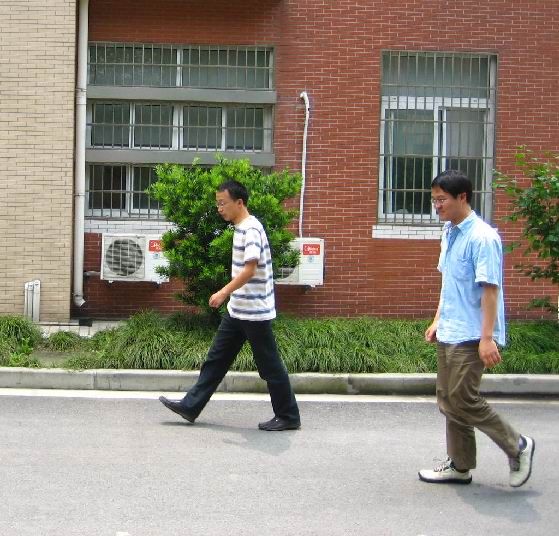

In [4]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

# Dısplay Instances

In [5]:
import random
import matplotlib.pyplot as plt
import os
import numpy as np


def display_instances(masks_path):
    rand_num=random.randint(0,len(os.listdir(masks_path)))
    rand_mask_name = os.listdir(masks_path)[rand_num]
    rand_mask = os.path.join(masks_path,rand_mask_name)
    mask=Image.open(rand_mask)
    mask=np.array(mask)
    
    # instances are encoded as different colors
    obj_ids = np.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]
    # print(obj_ids)
    
    i=1
    # plt.figure(figsize=(12,12))
    
    print(f'Detected {len(obj_ids)} instances.')
    for label in obj_ids:
        plt.figure(figsize=(12,12))
        instance_mask = np.where(mask==label,label,0)
        plt.subplot(1,len(obj_ids),i)
        plt.imshow(instance_mask)
        plt.xticks([])
        plt.yticks([])
        # print(label)
        i+=1
        

Detected 2 instances.


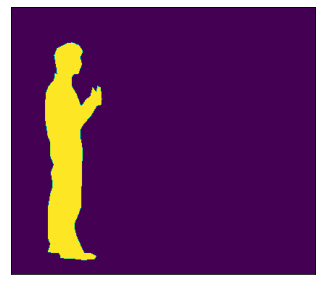

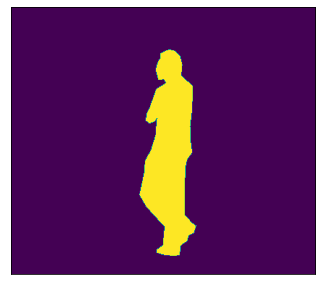

In [6]:
display_instances(MASKS_PATH)

# Define the dataset

In [308]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.12.0
True


In [7]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [8]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

# Define the model

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

# Training and evaluation functions
In references/detection/, we have a number of helper functions to simplify training and evaluating detection models. Here, we will use references/detection/engine.py, references/detection/utils.py and references/detection/transforms.py.

Let's copy those files (and their dependencies) in here so that they are available in the notebook



In [10]:
!git clone https://github.com/pytorch/vision.git

fatal: destination path 'vision' already exists and is not an empty directory.


In [11]:
# Copy all .py files into working directory of notepad.(references/detection/*.py)

# Define transformation function

In [12]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# Testing forward() method
Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.

In [13]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions



C:\Users\raufc\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\raufc\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

# Prepare the dataset and split

In [15]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

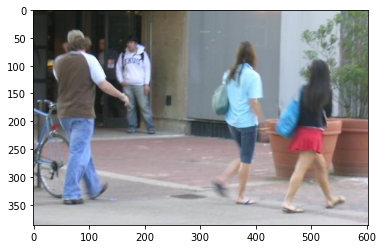

In [16]:
a,b=next(iter(data_loader))
a=a[0]
a=np.array(a).transpose(1,2,0)
plt.imshow(a)

# Set device and optimizer

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

C:\Users\raufc\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/120]  eta: 0:16:40  lr: 0.000047  loss: 1.7749 (1.7749)  loss_classifier: 0.6618 (0.6618)  loss_box_reg: 0.1062 (0.1062)  loss_mask: 0.9690 (0.9690)  loss_objectness: 0.0357 (0.0357)  loss_rpn_box_reg: 0.0022 (0.0022)  time: 8.3386  data: 0.0148  max mem: 972
Epoch: [0]  [ 10/120]  eta: 0:02:50  lr: 0.000467  loss: 1.4717 (1.5674)  loss_classifier: 0.5348 (0.4919)  loss_box_reg: 0.2540 (0.2584)  loss_mask: 0.6930 (0.7848)  loss_objectness: 0.0181 (0.0274)  loss_rpn_box_reg: 0.0031 (0.0050)  time: 1.5537  data: 0.0551  max mem: 1587
Epoch: [0]  [ 20/120]  eta: 0:02:00  lr: 0.000886  loss: 0.9876 (1.2250)  loss_classifier: 0.2490 (0.3524)  loss_box_reg: 0.2540 (0.2577)  loss_mask: 0.4786 (0.5862)  loss_objectness: 0.0107 (0.0227)  loss_rpn_box_reg: 0.0047 (0.0059)  time: 0.8451  data: 0.0385  max mem: 1612
Epoch: [0]  [ 30/120]  eta: 0:01:38  lr: 0.001306  loss: 0.7402 (1.0326)  loss_classifier: 0.1533 (0.2738)  loss_box_reg: 0.2250 (0.2488)  loss_mask: 0.3136 (0.4852)  

Epoch: [1]  [ 80/120]  eta: 0:00:33  lr: 0.005000  loss: 0.2231 (0.2852)  loss_classifier: 0.0275 (0.0404)  loss_box_reg: 0.0641 (0.0939)  loss_mask: 0.1132 (0.1429)  loss_objectness: 0.0002 (0.0023)  loss_rpn_box_reg: 0.0037 (0.0057)  time: 0.8061  data: 0.0100  max mem: 1702
Epoch: [1]  [ 90/120]  eta: 0:00:25  lr: 0.005000  loss: 0.2207 (0.2822)  loss_classifier: 0.0258 (0.0399)  loss_box_reg: 0.0618 (0.0925)  loss_mask: 0.1110 (0.1416)  loss_objectness: 0.0002 (0.0022)  loss_rpn_box_reg: 0.0038 (0.0060)  time: 0.8578  data: 0.0139  max mem: 1702
Epoch: [1]  [100/120]  eta: 0:00:16  lr: 0.005000  loss: 0.2335 (0.2886)  loss_classifier: 0.0299 (0.0401)  loss_box_reg: 0.0618 (0.0936)  loss_mask: 0.1337 (0.1464)  loss_objectness: 0.0005 (0.0021)  loss_rpn_box_reg: 0.0051 (0.0064)  time: 0.8762  data: 0.0164  max mem: 1702
Epoch: [1]  [110/120]  eta: 0:00:08  lr: 0.005000  loss: 0.2875 (0.2951)  loss_classifier: 0.0345 (0.0407)  loss_box_reg: 0.0645 (0.0966)  loss_mask: 0.1555 (0.1491) 

Epoch: [3]  [  0/120]  eta: 0:01:32  lr: 0.000500  loss: 0.1556 (0.1556)  loss_classifier: 0.0132 (0.0132)  loss_box_reg: 0.0289 (0.0289)  loss_mask: 0.1129 (0.1129)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 0.7713  data: 0.0156  max mem: 1702
Epoch: [3]  [ 10/120]  eta: 0:01:28  lr: 0.000500  loss: 0.1567 (0.2458)  loss_classifier: 0.0206 (0.0265)  loss_box_reg: 0.0343 (0.0692)  loss_mask: 0.1129 (0.1422)  loss_objectness: 0.0002 (0.0004)  loss_rpn_box_reg: 0.0027 (0.0075)  time: 0.8005  data: 0.0093  max mem: 1702
Epoch: [3]  [ 20/120]  eta: 0:01:19  lr: 0.000500  loss: 0.1736 (0.2217)  loss_classifier: 0.0206 (0.0252)  loss_box_reg: 0.0343 (0.0576)  loss_mask: 0.1016 (0.1319)  loss_objectness: 0.0003 (0.0005)  loss_rpn_box_reg: 0.0041 (0.0065)  time: 0.7956  data: 0.0076  max mem: 1702
Epoch: [3]  [ 30/120]  eta: 0:01:12  lr: 0.000500  loss: 0.1761 (0.2114)  loss_classifier: 0.0251 (0.0268)  loss_box_reg: 0.0362 (0.0527)  loss_mask: 0.1096 (0.1260) 

Epoch: [4]  [ 80/120]  eta: 0:00:32  lr: 0.000500  loss: 0.1581 (0.1838)  loss_classifier: 0.0201 (0.0244)  loss_box_reg: 0.0355 (0.0392)  loss_mask: 0.1070 (0.1159)  loss_objectness: 0.0007 (0.0014)  loss_rpn_box_reg: 0.0024 (0.0029)  time: 0.8274  data: 0.0118  max mem: 1702
Epoch: [4]  [ 90/120]  eta: 0:00:24  lr: 0.000500  loss: 0.1485 (0.1806)  loss_classifier: 0.0165 (0.0236)  loss_box_reg: 0.0273 (0.0381)  loss_mask: 0.1031 (0.1146)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0014 (0.0029)  time: 0.7988  data: 0.0126  max mem: 1702
Epoch: [4]  [100/120]  eta: 0:00:16  lr: 0.000500  loss: 0.1613 (0.1829)  loss_classifier: 0.0196 (0.0240)  loss_box_reg: 0.0250 (0.0401)  loss_mask: 0.0988 (0.1145)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0014 (0.0029)  time: 0.8091  data: 0.0107  max mem: 1702
Epoch: [4]  [110/120]  eta: 0:00:08  lr: 0.000500  loss: 0.1998 (0.1869)  loss_classifier: 0.0293 (0.0248)  loss_box_reg: 0.0413 (0.0420)  loss_mask: 0.1067 (0.1157) 

Epoch: [6]  [  0/120]  eta: 0:01:34  lr: 0.000050  loss: 0.1257 (0.1257)  loss_classifier: 0.0077 (0.0077)  loss_box_reg: 0.0253 (0.0253)  loss_mask: 0.0910 (0.0910)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 0.7842  data: 0.0000  max mem: 1702
Epoch: [6]  [ 10/120]  eta: 0:01:36  lr: 0.000050  loss: 0.1635 (0.1817)  loss_classifier: 0.0175 (0.0253)  loss_box_reg: 0.0272 (0.0386)  loss_mask: 0.1000 (0.1129)  loss_objectness: 0.0002 (0.0010)  loss_rpn_box_reg: 0.0015 (0.0039)  time: 0.8760  data: 0.0131  max mem: 1702
Epoch: [6]  [ 20/120]  eta: 0:01:26  lr: 0.000050  loss: 0.1635 (0.1774)  loss_classifier: 0.0228 (0.0254)  loss_box_reg: 0.0328 (0.0399)  loss_mask: 0.0990 (0.1080)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0021 (0.0034)  time: 0.8694  data: 0.0127  max mem: 1702
Epoch: [6]  [ 30/120]  eta: 0:01:16  lr: 0.000050  loss: 0.1519 (0.1769)  loss_classifier: 0.0218 (0.0253)  loss_box_reg: 0.0328 (0.0407)  loss_mask: 0.0929 (0.1072) 

Epoch: [7]  [ 80/120]  eta: 0:00:33  lr: 0.000050  loss: 0.1533 (0.1747)  loss_classifier: 0.0210 (0.0234)  loss_box_reg: 0.0260 (0.0356)  loss_mask: 0.1043 (0.1119)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0025 (0.0030)  time: 0.8645  data: 0.0133  max mem: 1702
Epoch: [7]  [ 90/120]  eta: 0:00:25  lr: 0.000050  loss: 0.1451 (0.1725)  loss_classifier: 0.0201 (0.0229)  loss_box_reg: 0.0209 (0.0348)  loss_mask: 0.0966 (0.1111)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0018 (0.0030)  time: 0.8447  data: 0.0133  max mem: 1702
Epoch: [7]  [100/120]  eta: 0:00:16  lr: 0.000050  loss: 0.1245 (0.1708)  loss_classifier: 0.0153 (0.0224)  loss_box_reg: 0.0209 (0.0346)  loss_mask: 0.0898 (0.1103)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0012 (0.0029)  time: 0.7944  data: 0.0117  max mem: 1702
Epoch: [7]  [110/120]  eta: 0:00:08  lr: 0.000050  loss: 0.1476 (0.1763)  loss_classifier: 0.0211 (0.0236)  loss_box_reg: 0.0279 (0.0367)  loss_mask: 0.1062 (0.1123) 

Epoch: [9]  [  0/120]  eta: 0:01:31  lr: 0.000005  loss: 0.1372 (0.1372)  loss_classifier: 0.0216 (0.0216)  loss_box_reg: 0.0301 (0.0301)  loss_mask: 0.0848 (0.0848)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 0.7665  data: 0.0156  max mem: 1702
Epoch: [9]  [ 10/120]  eta: 0:01:29  lr: 0.000005  loss: 0.1372 (0.1673)  loss_classifier: 0.0165 (0.0211)  loss_box_reg: 0.0261 (0.0336)  loss_mask: 0.0994 (0.1091)  loss_objectness: 0.0003 (0.0005)  loss_rpn_box_reg: 0.0012 (0.0029)  time: 0.8140  data: 0.0127  max mem: 1702
Epoch: [9]  [ 20/120]  eta: 0:01:24  lr: 0.000005  loss: 0.1555 (0.1696)  loss_classifier: 0.0173 (0.0220)  loss_box_reg: 0.0234 (0.0356)  loss_mask: 0.1011 (0.1088)  loss_objectness: 0.0003 (0.0005)  loss_rpn_box_reg: 0.0024 (0.0027)  time: 0.8437  data: 0.0109  max mem: 1702
Epoch: [9]  [ 30/120]  eta: 0:01:16  lr: 0.000005  loss: 0.1762 (0.1751)  loss_classifier: 0.0219 (0.0230)  loss_box_reg: 0.0344 (0.0375)  loss_mask: 0.1039 (0.1112) 

# Get prediction results 

In [296]:
# pick one image from the test set
img, _ = dataset_test[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [297]:
prediction

[{'boxes': tensor([[339.0350,  90.4031, 425.4446, 346.8003],
          [ 29.3553,  71.2864, 146.2445, 381.4097],
          [232.9138,  79.7179, 311.8872, 396.2412],
          [145.5733,  78.3026, 251.4736, 379.3161],
          [ 14.8868,  60.5233,  62.1070, 173.2219]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9972, 0.9971, 0.9956, 0.9886, 0.9450], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]

In [298]:
img.mul(255).permute(1, 2, 0).byte().numpy().shape

(411, 504, 3)

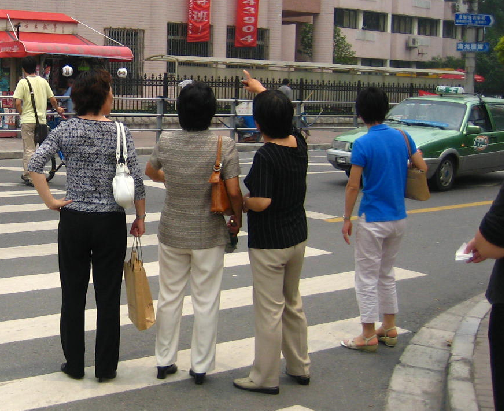

In [299]:
# Original image
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

# Prediction with instance segmentation

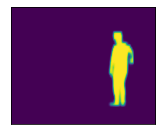

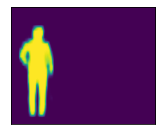

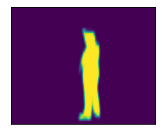

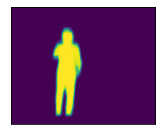

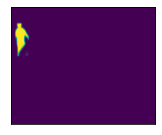

In [300]:
def display_predictions(prediction):
    
    # Define number of predicted instance
    num_instances=prediction[0]['masks'].shape[0]
    
    plt_count=1
    for instance in range(num_instances):
        # Create subplots for displaying predictions
        plt.figure(figsize=(15,10))
        plt.subplot(1,num_instances,plt_count)
        plt.imshow(prediction[0]['masks'][instance,0].mul(255).byte().cpu().numpy())
        plt_count+=1
        plt.xticks([])
        plt.yticks([])
display_predictions(prediction)

        

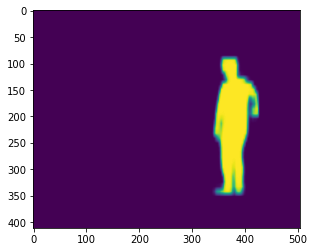

In [301]:
plt.imshow(prediction[0]['masks'][0,0].mul(255).byte().cpu().numpy())

In [303]:
pred_arr=prediction[0]['masks'][0,0].mul(255).byte().cpu().numpy()
pred_arr.shape

(411, 504)

In [304]:
prediction[0]['masks'].shape

torch.Size([5, 1, 411, 504])

In [305]:
def merged_pred_instances(prediction):
    
    # prediction[0]['masks'].shape --> torch.Size([7, 1, 315, 396]) 
    # 7 -> number of predicted instances
    # 1 -> redundant array
    # 315 -> height
    # 396 -> width

    
    height,width=(prediction[0]['masks'].shape[2],prediction[0]['masks'].shape[3])
    mask_rgb=np.zeros((height,width,3),dtype=np.uint8)
    new_mask_rgb = np.zeros((height,width,3),dtype=np.uint8)

    # Create a zero-mask,instances will be applied to this mask.
 
    merged_mask=np.zeros((height,width,3),dtype=np.uint8)
    
    # Define number of predicted instance
    num_instances=prediction[0]['masks'].shape[0]
    

    for instance in range(num_instances):           

        # Get predicted mask array of each instance.
        predicted_arr=prediction[0]['masks'][instance,0].mul(255).byte().cpu().numpy() # pred_arr.shape -->(315,396)
        
        mask_rgb[:,:,0]=predicted_arr
        mask_rgb[:,:,1]=predicted_arr
        mask_rgb[:,:,2]=predicted_arr
        
        rand_color=np.random.randint(0,255,size=(3,))
        
        new_mask_rgb=np.where((mask_rgb)!=0,rand_color,0) 
        
        idx=((new_mask_rgb)!=0)
        merged_mask[idx]=new_mask_rgb[idx]
        
    return merged_mask

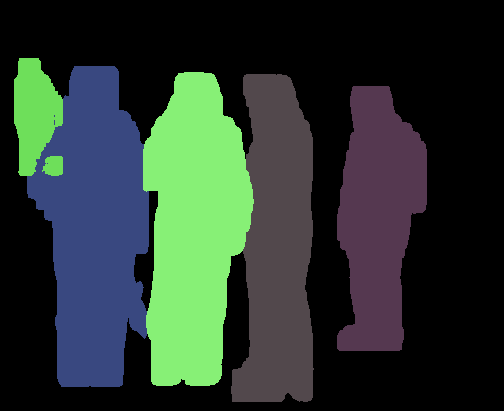

In [306]:
pred_merged_img=merged_pred_instances(prediction)
pred_merged_img=Image.fromarray(pred_merged_img)
pred_merged_img

# Prediction with object detection

In [321]:
pred_boxes=prediction[0]['boxes'] # Detected 5 bounding box (X0,Y0,X1,Y1)
pred_boxes

tensor([[339.0350,  90.4031, 425.4446, 346.8003],
        [ 29.3553,  71.2864, 146.2445, 381.4097],
        [232.9138,  79.7179, 311.8872, 396.2412],
        [145.5733,  78.3026, 251.4736, 379.3161],
        [ 14.8868,  60.5233,  62.1070, 173.2219]], device='cuda:0')

We'll draw the bounding boxes by using cv2.rectangle.Thus,we'll convert image to OpenCV format

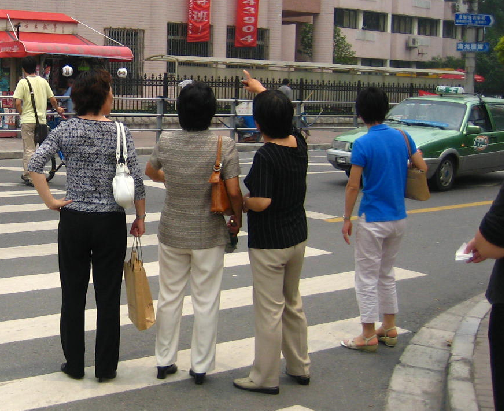

In [313]:
# Original image
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [357]:
import cv2

# Original image
test_img=img.mul(255).permute(1, 2, 0).byte().numpy()
test_img=cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)

for box in range(len(pred_boxes)):
    x0=int(pred_boxes[box][0].item())
    y0=int(pred_boxes[box][1].item())
    x1=int(pred_boxes[box][2].item())
    y1=int(pred_boxes[box][3].item())
    
    color=(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255))

    test_img=cv2.rectangle(test_img,(x0,y0),(x1,y1),color,2,8)


cv2.imwrite('predicted_obj_detection.jpg',test_img)

True

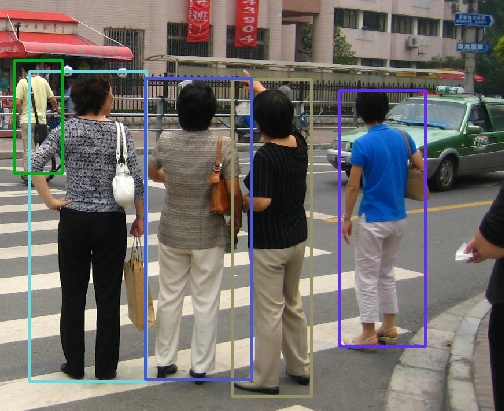

In [359]:
pred_img = Image.open('predicted_obj_detection.jpg')
pred_img

In [341]:
int(pred_boxes[0][0].item())

339

In [330]:
len(pred_boxes)

5

In [339]:
pred_boxes[1]

tensor([ 29.3553,  71.2864, 146.2445, 381.4097], device='cuda:0')

In [340]:
range(len(pred_boxes))

range(0, 5)

In [347]:
np.random.randint(0,255,size=(3,))

array([225, 243, 243])